In [7]:
import os
from PIL import Image
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn

from torchvision import transforms
import torchvision.transforms as T
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision.tv_tensors import BoundingBoxes
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from torchvision.models.detection import maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

/home/long/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, annot_dir, transform=None, mask_transform = None):
        self.img_dir = img_dir
        self.annot_dir = annot_dir
        self.transform = transform
        self.mask_transform = mask_transform

        
    def __getitem__(self, idx):
        img_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = read_image(img_path)
        height = img.size(1)
        width = img.size(2)
        channels = img.size(0)
        img_shape = (height, width, channels)
                 
        annot_name = img_name[:-3] + "xml"
        annot_path = os.path.join(self.annot_dir, annot_name)
        
        mask = self.parse_xml_to_mask(annot_path, img_shape)
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        object_id = torch.unique(mask)
        object_id_without_background = object_id[1:]
        num_object = len(object_id_without_background)
        
        masks = (mask == object_id_without_background[:, None, None]).to(dtype=torch.uint8)
        
        if self.transform: 
            img = self.transform(img)
        
        if self.mask_transform: 
            masks = self.mask_transform(masks)
        
        boxes = masks_to_boxes(masks)
                 
        labels = torch.ones((num_object,), dtype=torch.int64)
             
        target = {}
        target["boxes"] = boxes.to(torch.int)
        target["masks"] = masks
        target["labels"] = labels
        
        return img, target
                 
                 
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    
    def create_points_of_polygon(self, polygon):
        points = []
        i = 1
        
        while True:
            x_tag = f'x{i}'
            y_tag = f'y{i}'
            x = polygon.find(x_tag)
            y = polygon.find(y_tag)

            if x is None or y is None:
                break

            try:
                x = int(float(x.text))
                y = int(float(y.text))
                points.append((x, y))
            except Exception as e:
                print(f"Error parsing point {x_tag}, {y_tag} in {xml_path}: {e}")

            i += 1
        
        return points
    
    
    def parse_xml_to_mask(self, xml_path, image_shape):
        mask = np.zeros(image_shape[:2], dtype=np.uint8)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        obj_color = 1
        
        for obj in root.findall('object'):
            
            polygon = obj.find('polygon')

            points = self.create_points_of_polygon(polygon)

            if points:
                points = np.array(points, dtype=np.int32)
                cv2.fillPoly(mask, [points], color=obj_color)
                obj_color += 1
            else:
                print(f"No points found for an object in {xml_path}")
            
            

        return mask


In [9]:
transform = v2.Compose([
    v2.Resize([640, 640]), 
    v2.ToDtype(torch.float, scale=True)
])


# dataset = CustomDataset("data/vagabond/images/", "data/vagabond/label_panel_xml/", transform, transform)
dataset = CustomDataset("data/vagabond/sample_image/", "data/vagabond/sample_xml/", transform, transform)

<class 'dict'>
['boxes', 'masks', 'labels']
torch.Size([4, 4])
torch.Size([4, 640, 640])
torch.Size([4])
tensor([[377,   0, 639, 282],
        [ 48,   0, 411, 120],
        [ 48, 133, 389, 258],
        [ 44, 245, 639, 639]], dtype=torch.int32)


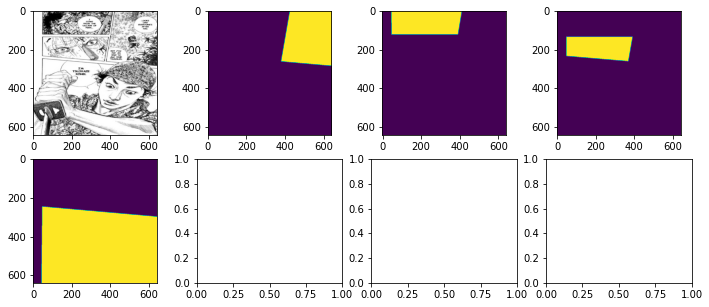

In [10]:
sample_idx = 0

img_sample = dataset[sample_idx][0]
target_sample = dataset[sample_idx][1]

print(type(target_sample))
print(list(target_sample.keys()))
print(target_sample['boxes'].size())
print(target_sample['masks'].size())
print(target_sample['labels'].size())
print(target_sample['boxes'])

_, ax = plt.subplots(2,4, figsize=(12,5))
ax[0,0].imshow(img_sample.permute(1,2,0))
ax[0,1].imshow(target_sample['masks'][0].squeeze())
ax[0,2].imshow(target_sample['masks'][1].squeeze())
ax[0,3].imshow(target_sample['masks'][2].squeeze())
ax[1,0].imshow(target_sample['masks'][3].squeeze())
# # ax[1,1].imshow(target_sample['masks'][4].squeeze())
# # ax[1,2].imshow(target_sample['masks'][5].squeeze())




In [11]:
generator = torch.Generator().manual_seed(42)

train_dataset, validation_dataset, test_dataset =  random_split(dataset, [0.8, 0.1, 0.1], generator=generator)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")      
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1
Validation dataset size: 0
Test dataset size: 0


/home/long/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(
/home/long/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:472: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [12]:
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [7]:
# train_dataset = CustomDataset("Panel-extraction-2/train", transforms=T.ToTensor())
# val_dataset = CustomDataset("Panel-extraction-2/valid", transforms=T.ToTensor())
# test_dataset = CustomDataset("Panel-extraction-2/test", transforms=T.ToTensor())
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [8]:
# model = maskrcnn_resnet50_fpn_v2(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = torch.nn.Linear(in_features, 2)
# model.roi_heads.mask_predictor = torch.nn.Conv2d(256, 2, kernel_size=(1, 1))

## Define model

In [98]:
model = maskrcnn_resnet50_fpn_v2(weights = None)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

## Testing output of model when in training mode and testing mode

In [49]:
img_sample, target_sample = next(iter(train_dataloader))
print(type(target_sample))
model.train()
target_sample = [{k: v for k, v in t.items()} for t in target_sample]
print(type(target_sample))

output = model(img_sample, target_sample)

<class 'tuple'>
<class 'list'>


In [11]:
print(type(output))
print(list(output.keys()))
loss = 0

for key in output.keys():
    loss += output[key]
    
print(loss)
print(sum(l for l in output.values()))

<class 'dict'>
['loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg']
tensor(1.7723, grad_fn=<AddBackward0>)
tensor(1.7723, grad_fn=<AddBackward0>)


In [12]:
model.eval()
output = model(img_sample)

In [14]:
print(type(output))
print(len(output))
print(list(output[0].keys()))
print('Box: ', output[0]['boxes'].size())
print('Labels: ', output[0]['labels'].size())
print('Scores: ', output[0]['scores'].size())
print('Masks: ', output[0]['masks'].size())

<class 'list'>
1
['boxes', 'labels', 'scores', 'masks']
Box:  torch.Size([100, 4])
Labels:  torch.Size([100])
Scores:  torch.Size([100])
Masks:  torch.Size([100, 1, 640, 640])


## Train

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Use {device}")

Use cuda


In [99]:
model.to(device)
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=0.0001)
num_epochs = 300
num_train_batch = len(train_dataloader)
# num_validation_batch = len(validation_dataloader)
defected_img = []
defected_targets = []
best_loss = 10

for epoch in range(num_epochs):
    print('-' * 60)
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    
    model.train()
    train_loss = 0
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        imgs, targets = data
        
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
        
        loss_dict = model(imgs, targets)
        loss_sum = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        loss_sum.backward()
        optimizer.step()
        
        train_loss += loss_sum
        running_loss += loss_sum
        
        if i % 50 == 49: 
            print(f'\t[{i+1}/{num_train_batch}] Loss: {running_loss/50}')
            running_loss = 0
        

#     val_loss = 0
#     with torch.no_grad():
#         for data in validation_dataloader:
#             imgs, targets = data
            
#             imgs = [img.to(device) for img in imgs]
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             loss_dict = model(imgs, targets)
#             val_loss += sum(loss for loss in loss_dict.values()).item()
            
            
#     print(f"Train loss: {train_loss/len(train_dataloader)} ,Validation Loss: {val_loss/len(validation_dataloader)}")
    loss_epoch = train_loss/len(train_dataloader)
    
    if loss_epoch < best_loss:
        best_loss = loss_epoch
    
    print(f"Train loss: {train_loss/len(train_dataloader)}")

torch.save(model.state_dict(), 'model/mask_rcnn.pth')

------------------------------------------------------------
Epoch [1/300]
Train loss: 7.4768242835998535
------------------------------------------------------------
Epoch [2/300]
Train loss: 5.789566516876221
------------------------------------------------------------
Epoch [3/300]
Train loss: 4.734677314758301
------------------------------------------------------------
Epoch [4/300]
Train loss: 3.806041717529297
------------------------------------------------------------
Epoch [5/300]
Train loss: 2.939486026763916
------------------------------------------------------------
Epoch [6/300]
Train loss: 2.1827821731567383
------------------------------------------------------------
Epoch [7/300]
Train loss: 1.7341601848602295
------------------------------------------------------------
Epoch [8/300]
Train loss: 1.2068463563919067
------------------------------------------------------------
Epoch [9/300]
Train loss: 1.036444067955017
---------------------------------------------------

Train loss: 0.19834382832050323
------------------------------------------------------------
Epoch [78/300]
Train loss: 0.2660668194293976
------------------------------------------------------------
Epoch [79/300]
Train loss: 0.25404202938079834
------------------------------------------------------------
Epoch [80/300]
Train loss: 0.25183406472206116
------------------------------------------------------------
Epoch [81/300]
Train loss: 0.25756311416625977
------------------------------------------------------------
Epoch [82/300]
Train loss: 0.2627749741077423
------------------------------------------------------------
Epoch [83/300]
Train loss: 0.2593366801738739
------------------------------------------------------------
Epoch [84/300]
Train loss: 0.283427894115448
------------------------------------------------------------
Epoch [85/300]
Train loss: 0.24611259996891022
------------------------------------------------------------
Epoch [86/300]
Train loss: 0.25520938634872437
-

Train loss: 0.09589561074972153
------------------------------------------------------------
Epoch [154/300]
Train loss: 0.08268608152866364
------------------------------------------------------------
Epoch [155/300]
Train loss: 0.09768456965684891
------------------------------------------------------------
Epoch [156/300]
Train loss: 0.0997125431895256
------------------------------------------------------------
Epoch [157/300]
Train loss: 0.09524358063936234
------------------------------------------------------------
Epoch [158/300]
Train loss: 0.09206081181764603
------------------------------------------------------------
Epoch [159/300]
Train loss: 0.0869612768292427
------------------------------------------------------------
Epoch [160/300]
Train loss: 0.08076835423707962
------------------------------------------------------------
Epoch [161/300]
Train loss: 0.11447594314813614
------------------------------------------------------------
Epoch [162/300]
Train loss: 0.0883889

Train loss: 0.039062488824129105
------------------------------------------------------------
Epoch [230/300]
Train loss: 0.045796167105436325
------------------------------------------------------------
Epoch [231/300]
Train loss: 0.04626745730638504
------------------------------------------------------------
Epoch [232/300]
Train loss: 0.04846640303730965
------------------------------------------------------------
Epoch [233/300]
Train loss: 0.0465744212269783
------------------------------------------------------------
Epoch [234/300]
Train loss: 0.04872018098831177
------------------------------------------------------------
Epoch [235/300]
Train loss: 0.04418491944670677
------------------------------------------------------------
Epoch [236/300]
Train loss: 0.04685811325907707
------------------------------------------------------------
Epoch [237/300]
Train loss: 0.038540612906217575
------------------------------------------------------------
Epoch [238/300]
Train loss: 0.054

In [15]:
model = maskrcnn_resnet50_fpn_v2(weights = None)
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)


model.load_state_dict(torch.load('model/mask_rcnn.pth', weights_only=True))

model.to(device)
model.eval()
for i, data in enumerate(train_dataloader):
    imgs, targets = data

    imgs = [img.to(device) for img in imgs]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    with torch.no_grad():
        output = model(imgs)

<class 'list'>
1
['boxes', 'labels', 'scores', 'masks']
Box:  torch.Size([4, 4])
Labels:  torch.Size([4])
Scores:  torch.Size([4])
Masks:  torch.Size([4, 1, 640, 640])
tensor([0.0000e+00, 6.2764e-13, 6.4938e-13,  ..., 6.5524e-03, 6.9447e-03,
        7.0049e-03], device='cuda:0')


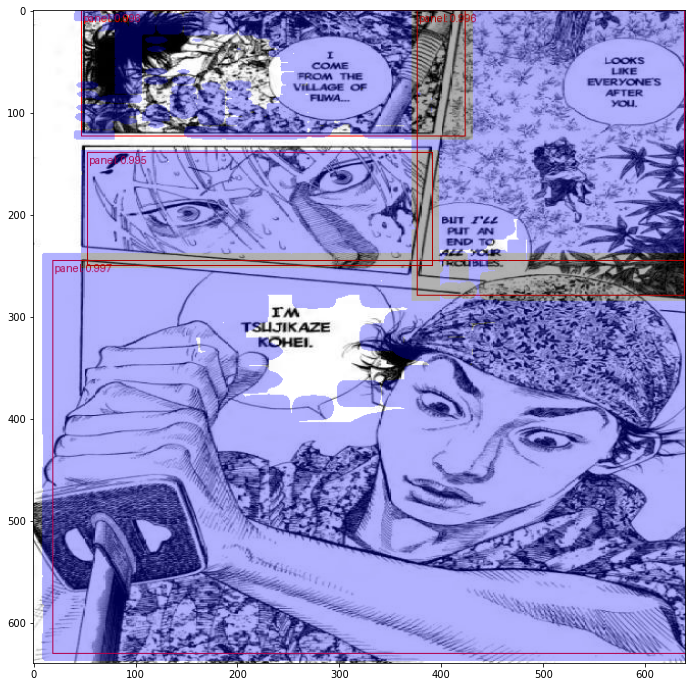

In [16]:
pred = output[0]
image = imgs[0]
sigmoid = nn.Sigmoid()
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

pred_labels = [f"panel: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
masks = (sigmoid(pred["masks"]) > 0.5).squeeze(1)

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

output_image = draw_segmentation_masks(output_image, masks, alpha=0.3, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))


# plt.imshow(imgs[0].permute(1,2,0).cpu())

print(type(output))
print(len(output))
print(list(output[0].keys()))
print('Box: ', output[0]['boxes'].size())
print('Labels: ', output[0]['labels'].size())
print('Scores: ', output[0]['scores'].size())
print('Masks: ', output[0]['masks'].size())

mask_values = pred['masks'].unique()
print(mask_values)
# for i in range(mask_values.size(0)):
#     print(mask_values[i])


In [ ]:
# model.eval()
# test_results = []
# with torch.no_grad():
#     for images, _ in test_loader:
#         images = [img.to(device) for img in images]
#         predictions = model(images)
#         test_results.extend(predictions)

In [4]:
!nvidia-smi

Sun Nov 10 21:42:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        Off | 00000000:02:00.0 Off |                  N/A |
| 30%   45C    P2              70W / 170W |  10546MiB / 12288MiB |     86%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--